# Using remotely-sensed NDVI to understand temporal and spatial patterns of grassland brown-down in Boulder County, Colorado

Advyth Ramachandran

Department of Ecology & Evolutionary Biology,
University of Colorado, Boulder

*Class Final Project for Earth Analytics Bootcamp, Fall 2023*

> *Disclaimer:*
>
> *The work in this notebook was generated for a class project, is not reviewed, and all findings should be considered preliminary*.


## **Project Description**

Tracking vegetation phenology – the timing of plant growth and physiological processes – is critical to understanding plant response to drought and identifying areas with plant mortality which can create high fire hazard (Li et al. 2023, Bowman et al. 2020, Gemitzi & Koutsias 2021). Changes in plant phenology can be used to understand plant responses to drought, providing information that is relevant to land managers. In semi-arid and arid climates, the timing of plant green-up after the wet season onset and brown-down after dry season onset can change in response to periodic weather fluctuations and seasonal drought, both of which may be altered by climate change (Swain 2021).

Examining past temporal trends in phenology is the first step to hypothesizing about future changes in vegetation phenology, which is important to understand as climate change may alter vegetation phenology in ways that amplify fire risk. For example, if climatic warming delays the onset of the winter rainy season by extending the summer/fall seasonal dry period, the temporal co-occurrence of extreme wind events and dry fuels which together create the conditions for rapid fire spread upon ignition, can increase (Swain 2021). In Colorado, extreme wind events in the fall and winter, during which grassland vegetation is senesced (dead and dry), have fueled rapid wildfires such as the 2021 Marshall Fire (Fovell, Brewer, and Garmong 2022). In such semi-arid climates, forecasting the timing of vegetation senescence in the fall dry season is crucial to predicting fire risk.

However, plant phenology is spatially variable. While it is widely known that vegetation types differ in the time of senescence (e.g., forest versus grassland), how finer-scale vegetation communities (e.g., shortgrass versus tallgrass prairie) differ in the time of senescence is less clear. In urban and peri-urban areas, understanding when various grassland types senesce in the fall can help identify grassland patches of high fire hazard; that is, patches where the fall brown-down date is earlier, potentially increasing the chance of the co-occurrence of fire weather and dry fuels. In wildland areas where fire risk is less of a management concern, the time of senescence can inform the timing of management interventions to enhance biodiversity such as grazing to remove dominant invasive grass thatch.

Remote sensing can be used to track vegetation phenology over time at larger spatial scales than traditional field-based monitoring. While a variety of remotely-sensed metrics can be used to infer vegetation phenology, NDVI is a commonly used metric that quantifies vegetation greenness (Ren et al. 2018) and is relatively consistent with phenology derived from other methods such as phenological cameras (Richardson et al. 2018). If NDVI is very low at a particular location compared to other NDVI values at that location, we can infer that the vegetation has begun to or has already senesced.

**Questions**

For grassland vegetation in Boulder County, Colorado, I asked:

1.	Can remote sensing data be used to detect vegetation senescence across space and different vegetation community types?
2.	Do distinct vegetation communities (e.g., mixed versus tallgrass versus shortgrass prairie) differ in the timing of vegetation senescence?
3.	Is the timing of vegetation senescence changing over time (possible due to climatic warming)?

## **Site Description**

Boulder County, located in the state of Colorado, U.S.A., sits at an elevation of about 5,400 feet above sea level (Wikipedia Contributors) and contains a variety of vegetation communities ranging from shortgrass prairie and tallgrass prairie to shrublands, montane forest, and alpine areas (City of Boulder 2021).

Below the Rocky Mountain foothills, Boulder County is within the Great Plains region, and has a steppe climate with 10-20 inches of precipitation per year, which occurs year-round, and hot summers (Wikipedia Contributors). Snow falls between October and May. The vegetation in the Great Plains portion of the county is predominantly grassland comprising a mix of grasses and forbs; there are few trees outside of riparian zones (CoNPS n.d.). Plants typically flower from early April through early-to-mid October (CoNPS n.d.).

## **Data Description**

**_NDVI Remote Sensing Data_**

To quantify vegetation brown-down dates, I used data generated by the MODIS (or Moderate Resolution Imaging Spectroradiometer) instrument aboard the Aqua satellite. The U.S. National Aeronautics and Space Administration (NASA) provides a normalized difference vegetation index (NDVI) data product at a 16-day resolution at 250 meter pixel resolution (Didan 2021). The time span of this data ranges from from 2002-2023. The NDVI layer provided by the U.S. National Aeronautics and Space Administration(NASA) is generated using an algorithm that chooses the best available pixel value from all images in the 16 day period, accounting for anomalies and low clouds (Didan 2021).

It is important to note that snow cover and cloud cover can influence NDVI values (Bradley et al. 2007). Future work could re-run this analysis using a curve fitting procedure with smoothing as in Bradley et al. (2007) to address these issues.

**_Vegetation Type Data_**

To test whether NDVI differed among vegetation types, I compared NDVI values to vegetation polygons field-mapped by the City of Boulder Open Space & Mountain Parks Department (OSMP). The Department manages a great variety of ecosystems, mostly in the grasslands and montane forest surrounding the City of Boulder. OSMP has conducted extensive vegetation mapping of land the department manages, categorizing vegetation using the U.S. National Vegetation Classification (USNVC) system which includes several hierarchical categories (City of Boulder 2021). The target level for mapping on OSMP land is the Association level which includes types that are part of the USNVC but also types created by OSMP (City of Boulder 2021). The Association describes dominant species in the vegetation type. The Association are pooled into Macrogroups.

> Data Citations:
>
> Didan, K.. MODIS/Aqua Vegetation Indices 16-Day L3 Global 250m SIN Grid V061. 2021, distributed by NASA EOSDIS Land Processes Distributed Active Archive Center, https://doi.org/10.5067/MODIS/MYD13Q1.061. Accessed 2023-12-18.
> 
> City of Boulder. 2021. OSMP Vegetation (USNVC Alliances). Date updated: November 7, 2023. Date accessed: December 18, 2023. https://open-data.bouldercolorado.gov/datasets/18555477ea2742a19feed47370f98e7b_1/about.

## **Analysis**

## Load libraries

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
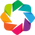

In [31]:
# Load libraries
# import cartopy.crs as ccrs
import pathlib
import earthpy as et
import earthpy.earthexplorer as etee
import earthpy.appeears as etapp
import pandas as pd
import geopandas as gpd
import geoviews as gv
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import regionmask
import rioxarray as rxr
import seaborn as sns
import xarray as xr

from glob import glob
from shapely.geometry import box, Polygon

hv.extension('bokeh')
gv.extension("bokeh")

## Download data

In [32]:
# Make data directories

data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'boulder-grasslands')
ndvi_dir = os.path.join(data_dir, 'ndvi-data')
veg_type_dir = os.path.join(data_dir, 'veg-type-data')

ndvi_processed_data_path = os.path.join(ndvi_dir, 'processed_data')

for a_dir in [ndvi_dir, veg_type_dir, ndvi_processed_data_path]:
    if not os.path.exists(a_dir):
        os.makedirs(a_dir)

Download vegetation community type data.

In [33]:
# Test: Download for one chunk
# veg_one_chunk_url = (
#     "https://gis.bouldercolorado.gov/ags_svr2/rest/services/osmp/"
#     "OSMPVegetation/MapServer/1/query?"
#     "where=OBJECTID%20%3E%3D%20{min_objectid}%20AND"
#     "%20OBJECTID%20%3C%3D%20{max_objectid}"
#     "&outFields=*&outSR=4326&f=geojson"
# )

# user_agent = (
#     'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
#     'Gecko/20100101 Firefox/81.0'
# )
# r = requests.get(url=veg_one_chunk_url
#                  .format(min_objectid=11444,
#                          max_objectid=11447),
#                  headers={'User-Agent': user_agent})

# # Read GeoJSON data into a GeoDataFrame
# geojson_data = r.json()

# veg_one_chunk_gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# veg_one_chunk_gdf

In [34]:
# Download vegetation type data if it has not already been downloaded.

print("Checking if data is downloaded...")
veg_type_path = os.path.join(veg_type_dir, 'veg_type.geojson')

if os.path.exists(veg_type_path):
    print("Data is already downloaded.")
else:
    print("Data is not downloaded. Initiating download...")

    # Define URL
    veg_url = (
        "https://gis.bouldercolorado.gov/ags_svr2/rest/services/osmp/"
        "OSMPVegetation/MapServer/1/query?"
        "where=1%3D1&outFields=*"
        "&returnGeometry=false"
        "&returnIdsOnly=true&outSR=4326&f=json"
    )

    # Mimic web browser
    user_agent = (
        'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
        'Gecko/20100101 Firefox/81.0'
    )

    # Download GEOJSON
    r = requests.get(url=veg_url, headers={'User-Agent': user_agent})

    # Read GeoJSON data into a GeoDataFrame
    geojson_data = r.json()

    # Extract the objectIDs (the indexes of the rows in the dataset)
    objectid_list = geojson_data["objectIds"]

    # Define chunks from the row numbers
    chunks = [
        (objectid_list[i],
            objectid_list[min(i + 1000,
                              len(objectid_list)-1)])
        for i in range(0, len(objectid_list), 1000)
    ]
    print("Data chunks identified.")

    # Due to the City of Boulder ArcGIS Hub limit of downloading
    # a maximum of 1,000 items at a time,
    # split the dataset into chunks and download the chunks individually.

    veg_list = []

    # Download data for each chunk
    for (min_objectid, max_objectid) in chunks:

        print("Downloading chunk.")

        # Define url
        veg_url = (
            "https://gis.bouldercolorado.gov/ags_svr2/rest/services/"
            "osmp/OSMPVegetation/MapServer/1/query?"
            "where=OBJECTID%20%3E%3D%20{min_objectid}"
            "%20AND%20OBJECTID%20%3C%3D%20{max_objectid}"
            "&outFields=*&outSR=4326&f=geojson"
        )

        # Mimic web browser
        user_agent = (
            'Mozilla/5.0 (X11; Linux x86_64; rv:60.0) '
            'Gecko/20100101 Firefox/81.0'
        )

        # Download chunk of data
        r = requests.get(url=veg_url.format(
            min_objectid=min_objectid,
            max_objectid=max_objectid),
            headers={'User-Agent': user_agent})

        # Read GeoJSON data into a GeoDataFrame
        geojson_data = r.json()
        veg_chunk_gdf = (gpd.GeoDataFrame
                         .from_features(geojson_data['features'])
        )

        # Add the chunk gdf to the list
        veg_list.append(veg_chunk_gdf)

        print("Done.")

    # Concatenate the chunk gdfs into one gdf
    veg_gdf = pd.concat(veg_list)

    # Save downloaded data to CSV in directory
    veg_gdf.to_file(veg_type_path, driver='GeoJSON')
    print("Saved data to GeoJSON.")

Checking if data is downloaded...
Data is already downloaded.


Download NDVI data.

In [35]:
# Load vegetation data
veg_gdf = gpd.read_file(veg_type_path)

# Calculate the total bounds
bounding_box = veg_gdf.total_bounds

# Create a polygon from the bounding box
minx, miny, maxx, maxy = bounding_box
bounding_box_polygon = box(minx, miny, maxx, maxy)
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box_polygon],
                                    crs=veg_gdf.crs)

print(bounding_box_gdf)

                                            geometry
0  POLYGON ((-105.10754 39.86615, -105.10754 40.1...


In [36]:
# To test bbox code

# bbox_map = bounding_box_gdf.hvplot(
#     geo=True,
#     line_color='black',
#     fill_alpha=0,
#     tiles='EsriImagery'
# ).opts(
#     width=800,
#     height=800,
#     show_legend=False  # Set legend to False to remove it
# )

# bbox_map

In [37]:
# Initialize AppeearsDownloader for MODIS NDVI data

ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=ndvi_dir,
    product="MYD13Q1.061",  # from list of APPEEARS datasts
    layer="_250m_16_days_NDVI",
    start_date="01-01",
    end_date="12-31",
    recurring=True,
    year_range=[2015, 2022],
    polygon=bounding_box_gdf,
)

# Download files if the download directory does not exist
if os.path.exists(ndvi_downloader.data_dir):
    print("MODIS NDVI data is already downloaded.")
else:
    print("Downloading MODIS NDVI data.")
    ndvi_downloader.download_files()

ndvi_downloader

MODIS NDVI data is already downloaded.


In [38]:
# Merge NDVI arrays into Dataset and cache result

# Define NDVI processed data path
ndvi_combined_path = os.path.join(ndvi_processed_data_path, "ndvi_data.nc")


# Load and merge arrays only if the processed data has not already been created
if os.path.exists(ndvi_combined_path):
    print("NDVI data has already been merged and processed.")
else:
    print("Merging and processing data.")

    # Generate list of data files
    ndvi_path_list = glob(
        os.path.join(ndvi_downloader.data_dir, "*", "*NDVI*.tif")
    )

    # Merge images into a single data array

    doy_start = -19  # the character number of the start of doy in file name
    doy_end = -12  # the character number of the end of doy in file name
    scale_factor = 10000  # from MODIS data documentation

    # Define a list
    ndvi_da_list = []

    # For every file (.tif image), add it to the list
    for ndvi_path in ndvi_path_list:
        # Get date from file name
        doy = ndvi_path[doy_start:doy_end]

        # Define the date variable as the doy in file name
        date = pd.to_datetime(doy, format='%Y%j')

        # Open dataset
        da = rxr.open_rasterio(ndvi_path,
                               # masked=True changes specific excluded
                               # values from the metadata to NaN values
                               masked=True).squeeze()

        # Prepare to concatenate: Add date dimension and clean up metadata
        da = da.assign_coords({'date': date})
        da = da.expand_dims({'date': 1})
        da.name = 'NDVI'

        # Divide by scale factor (see data citation for details)
        da = da / scale_factor

        # Add the DataArray to the end of the accumulator list
        ndvi_da_list.append(da)
        print("Added .tif data to data array list.")

    # Stack arrays into time series
    ndvi_dataset = xr.combine_by_coords(ndvi_da_list, coords=["date"])
    print("Stacked arrays into data set.")

    # Cache the ndvi dataset as a netCDF
    ndvi_dataset.to_netcdf(path=ndvi_combined_path)
    print("Created netCDF file.")

NDVI data has already been merged and processed.


## Load and explore data

<Axes: >

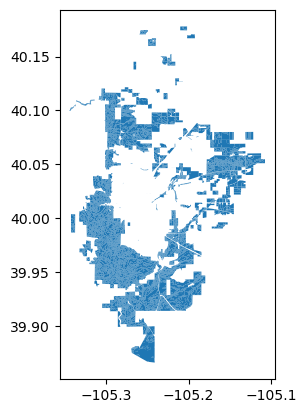

In [39]:
# View vegetation data
veg_gdf

# Test plot: vegetation polygons
veg_gdf.plot()

(array([  5548., 133180., 103449., 632070., 749540., 666482., 628412.,
        255148.,  28441.,   1155.]),
 array([-0.2       , -0.08016001,  0.03967999,  0.15951999,  0.27936   ,
         0.39919999,  0.51903999,  0.63887995,  0.75871998,  0.87855995,
         0.99839997]),
 <BarContainer object of 10 artists>)

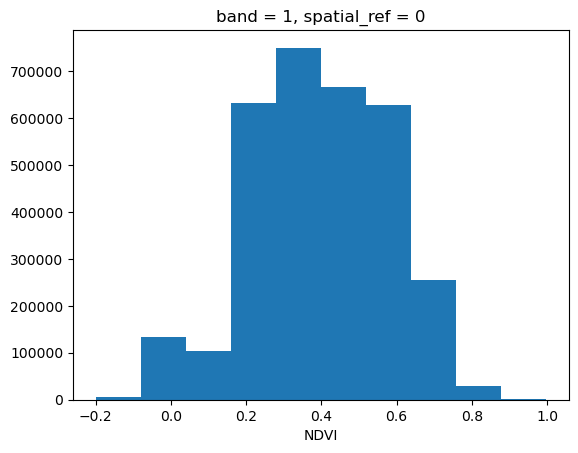

In [40]:
# Load NDVI data
ndvi_ds = xr.open_dataset(ndvi_combined_path)
ndvi_ds

# Generate histogram of NDVI
ndvi_ds.NDVI.plot()

NDVI [should take values between -1.0 and 1.0.](https://ipad.fas.usda.gov/cropexplorer/Definitions/spotveg.htm) Verify that NDVI falls within expected values.

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

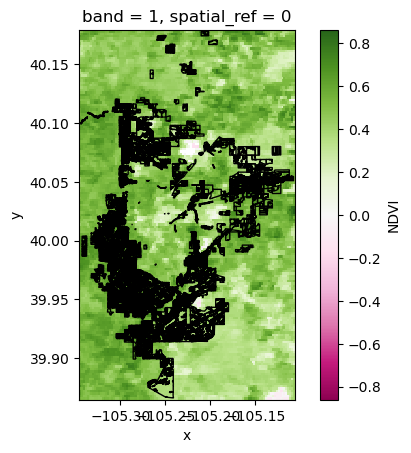

In [41]:
# Test plot: Plot NDVI in 2022

# Select NDVI in 2022 June
ndvi_2022_da = (ndvi_ds
                .sel(date='2022-06')
                .mean('date')
                .NDVI)

# Plot with matplotlib
ndvi_2022_da.plot(cmap=plt.colormaps['PiYG'])
veg_gdf.plot(facecolor='none', ax=plt.gca())

### Visualize NDVI patterns over time

In [42]:
ndvi_time = gv.Dataset(ndvi_ds, kdims=['x', 'y', 'date'], vdims=['NDVI'])

ndvi_plot = ndvi_time.to(gv.Image).opts(
    cmap='greens', colorbar=True, alpha=0.8, tools=['hover'], width=700, height=500)
ndvi_ref_plot = ndvi_plot * gv.tile_sources.OSM()

# hv.save(ndvi_ref_plot, 'test_ndvi_over_time.html')

Now, only visualize NDVI within the vegetation polygon boundaries (i.e., ignore all NDVI pixels for which we will not calculate brown-down such as urban and agricultural lands).

In [43]:
# Before clipping, check CRS
print(veg_gdf.crs)
print(ndvi_ds.rio.crs)

EPSG:4326
EPSG:4326


In [44]:
# Clip raster to polygons
ndvi_ds_veg_only = ndvi_ds.rio.clip(veg_gdf.geometry, all_touched=True)
print(ndvi_ds_veg_only.rio.crs)

EPSG:4326


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

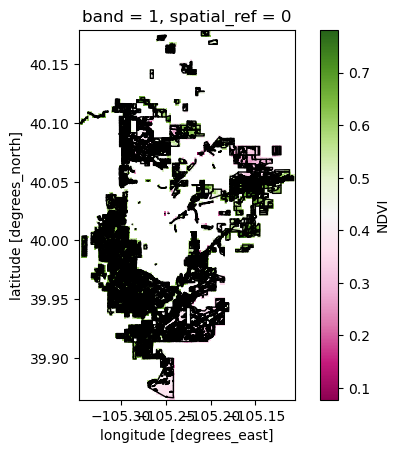

In [45]:
# Plot clipped data

# Calculate NDVI in 2022 June
ndvi_2022_clipped_da = (ndvi_ds_veg_only
                        .sel(date='2022-06')
                        .mean('date')
                        .NDVI)

# Plot with matplotlib
ndvi_2022_clipped_da.plot(cmap=plt.colormaps['PiYG'])
veg_gdf.plot(facecolor='none', ax=plt.gca())

## Calculate brown-down

For each MODIS NDVI pixel, I estimated the brown-down date, which is the day of year for each year where the vegetation is senesced in fall at the end of the summer growing season. In Boulder County, the growing season is spring-summer.

The brown-down date for each pixel was calculated using a percentile threshold as in Marchin et al. (2018) and Browning et al. (2017), as the earliest date (lowest day of year) where the NDVI value is at or below the 10th percentile value for that year. The 10th percentile NDVI was calculated for each year and is relative to the lowest NDVI value within that year, to account for potential differences among years in minimum NDVI values. For the purpose of this preliminary analysis, I was interested in seeing whether brown-down timing was different among years and vegetation types regardless of interannual variation in plant production between years. For example, in a wet year the brown-down represents the day of year where the vegetation was at the 10th percentile "brownest" in comparison to its distribution of NDVI for that year, while in a dry year the brown-down represents the day where the vegetation was 10th percentile brownest for that year's distribution of NDVI. The brown-down date, therefore, may correspond to different values of 10th percentile NDVI for each year, for the same location.

It should be noted that other methods to extract phenology from NDVI exist and may be more accurate, such as procedures to fit NDVI curves using a double-logistic function (Bradley et al. 2007, Ren et al. 2018). Further work could re-run the analysis applying such methods to calculate brown-down.

In [46]:
# Calculate percentile thresholds
thresholds_df = (ndvi_ds.to_dataframe()
                 .reset_index()
                 # Select only June-December dates - we are
                 # not interested in green-up after snowmelt
                 .loc[lambda x: (x['date'].dt.month >= 6) & (x['date'].dt.month <= 12)]
                 # Convert the data coordinate to column
                 .assign(year=lambda x: x['date'].dt.year)
                 # Calculate 10th percentile value
                 .groupby(['x', 'y', 'year'])
                 .agg(threshold=('NDVI', lambda x: x.quantile(0.1)))

                 )
thresholds_df

threshold
x           y         year           
-105.344792 39.865625 2014    0.07610
                      2015    0.33198
                      2016    0.42297
                      2017    0.42143
                      2018    0.39556
...                               ...
-105.107292 40.178125 2018    0.31790
                      2019    0.28315
                      2020    0.31441
                      2021    0.30435
                      2022    0.28896

[156285 rows x 1 columns]

In [47]:
# Identify the 10th percentile dates of greenness

dates_da = (ndvi_ds_veg_only.to_dataframe()
            .reset_index()
            # Select only June-December dates - we are
            # not interested in green-up after snowmelt
            .loc[lambda x: (x['date'].dt.month >= 6) 
                 & (x['date'].dt.month <= 12)]
            # Convert the data coordinate to column
            .assign(year=lambda x: x['date'].dt.year)
            # Left-join the thresholds by columns x, y, year
            .merge(thresholds_df, on=['x', 'y', 'year'], how='left')
            # Create a new column for TF the ndvi value falls at
            # or under the threshold
            .assign(is_below_threshold=lambda x: x['NDVI'] <= x['threshold'])
            # Remove all False columns
            .loc[lambda x: x['is_below_threshold']]
            # Group by x, y, year, select lowest dates
            .groupby(['x', 'y', 'year'])
            .agg(min_date=('date', 'min'))
            .to_xarray()

            )

# Create day of year from date column
dates_da['day_of_year'] = dates_da.min_date.dt.dayofyear

In [48]:
# Add in a CRS
dates_da = dates_da.rio.write_crs(ndvi_ds_veg_only.rio.crs)
print(dates_da.rio.crs)
dates_da

EPSG:4326


<xarray.Dataset>
Dimensions:      (x: 115, y: 146, year: 9)
Coordinates:
  * x            (x) float64 -105.3 -105.3 -105.3 ... -105.1 -105.1 -105.1
  * y            (y) float64 39.87 39.87 39.87 39.87 ... 40.17 40.17 40.18 40.18
  * year         (year) int32 2014 2015 2016 2017 2018 2019 2020 2021 2022
    spatial_ref  int64 0
Data variables:
    min_date     (x, y, year) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    day_of_year  (x, y, year) float64 nan nan nan nan nan ... nan nan nan nan

EPSG:4326
EPSG:4326


<Axes: title={'center': 'year = 2022, spatial_ref = 0'}, xlabel='x', ylabel='y'>

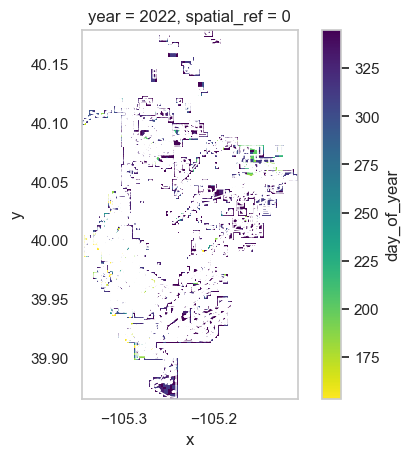

In [55]:
# Test plot to verify dates were calculated

print(veg_gdf.crs)
print(dates_da.rio.crs)

dates_2022_da = (dates_da
                     .sel(year=2022)
                     .day_of_year)

# Plot with matplotlib
dates_2022_da.plot(x='x', y='y', cmap=plt.colormaps['viridis_r'])
veg_gdf.plot(facecolor='none', ax=plt.gca())

Calculate zonal mean brown-down date for each vegetation patch (polygon).

In [129]:
# Select only day of year
dates_array = dates_da['day_of_year']

# Create mask of multiple regions from shapefile
veg_mask = regionmask.mask_3D_geopandas(
    veg_gdf,
    dates_array.x,
    dates_array.y,
    drop=True,
    overlap=True,
    numbers="OBJECTID"
)

# Apply mask on dates data
dates_array = dates_array.where(veg_mask)


# Calculate means by veg polygon and year
veg_avg_doy_ds = (dates_array
                    .groupby("region")
                    .mean(["x", "y"], skipna=True)
                    )

# Convert to dataframe
veg_avg_doy_df = (veg_avg_doy_ds.to_dataframe()
                    .apply(lambda x: x.dropna())
                    .sort_values(by=['region', 'year'])
                    )

veg_avg_doy_df

spatial_ref  day_of_year
year region                          
2014 10448             0        361.0
2015 10448             0        345.0
2016 10448             0        345.0
2017 10448             0        345.0
2018 10448             0        329.0
...                  ...          ...
     20748             0        345.0
2019 20748             0        329.0
2020 20748             0        345.0
2021 20748             0        345.0
2022 20748             0        345.0

[19017 rows x 2 columns]

In [130]:
veg_avg_doy_df.index
veg_avg_doy_df.dtypes

spatial_ref      int64
day_of_year    float64
dtype: object

In [144]:
veg_avg_dates_df = veg_avg_doy_df.copy()

# Assuming 'day_of_year' is a column, not part of the MultiIndex
veg_avg_dates_df['day_of_year'] = veg_avg_dates_df['day_of_year'].astype(int).apply(lambda x: f'{x:03d}')

# Assuming 'year' is part of a MultiIndex
veg_avg_dates_df = veg_avg_dates_df.reset_index()  # Reset the entire MultiIndex
veg_avg_dates_df['date_of_browndown'] = pd.to_datetime(veg_avg_dates_df['year'].astype(str) + veg_avg_dates_df['day_of_year'], format='%Y%j')

type(veg_avg_dates_df)
veg_avg_dates_df

,year,region,spatial_ref,day_of_year,date_of_browndown
0,2014,10448,0,361,2014-12-27
1,2015,10448,0,345,2015-12-11
2,2016,10448,0,345,2016-12-10
3,2017,10448,0,345,2017-12-11
4,2018,10448,0,329,2018-11-25
...,...,...,...,...,...
19012,2018,20748,0,345,2018-12-11
19013,2019,20748,0,329,2019-11-25
19014,2020,20748,0,345,2020-12-10
19015,2021,20748,0,345,2021-12-11


float64


<Axes: ylabel='Frequency'>

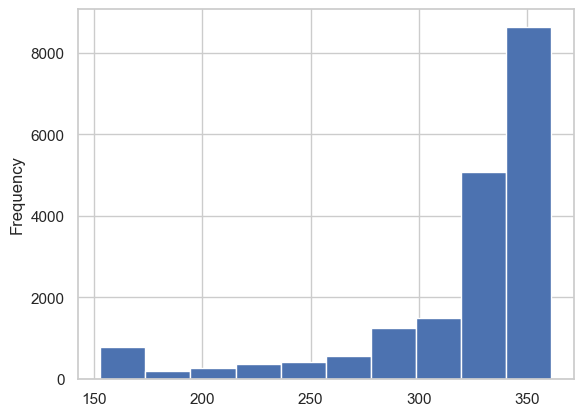

In [152]:
# Convert back into float for plotting
veg_avg_dates_df['day_of_year'] = veg_avg_dates_df['day_of_year'].astype(float)
print(veg_avg_dates_df['day_of_year'].dtype)
veg_avg_dates_df

# Test plot
veg_avg_dates_df['day_of_year'].plot.hist()

In [153]:
# Merge average dates by vegetation patch
# with original vegetation to retrieve geometry
veg_avg_dates_gdf = (veg_avg_dates_df
                     .reset_index()
                     .merge(veg_gdf, left_on='region',
                            right_on='OBJECTID',
                            how='left')
                     .sort_values(by=['region', 'year'])

                     # Convert to gdf
                     .pipe(gpd.GeoDataFrame, geometry='geometry')
                     )

# Remove rows with NaN values for plotting
veg_avg_dates_gdf = (veg_avg_dates_gdf
                     .loc[veg_avg_dates_gdf['day_of_year']
                          .notna()]
                     )

print(type(veg_avg_dates_gdf))
veg_avg_dates_gdf

<class 'geopandas.geodataframe.GeoDataFrame'>


,index,year,region,spatial_ref,day_of_year,date_of_browndown,OBJECTID,USNVCKEY,SCIENTIFICNAME,COLLOQUIALNAME,MACROGROUP,SUBCLASS,CONSTARGET,WETLAND,ACRES,URL,GlobalID,Shape.STArea(),Shape.STLength(),geometry
0,0,2014,10448,0,361.0,2014-12-27,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
1,1,2015,10448,0,345.0,2015-12-11,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
2,2,2016,10448,0,345.0,2016-12-10,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
3,3,2017,10448,0,345.0,2017-12-11,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
4,4,2018,10448,0,329.0,2018-11-25,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19012,19012,2018,20748,0,345.0,2018-12-11,20748,None,None,None,None,None,None,None,9.648047,None,{7AE3C8CA-CA41-43DE-B3A6-0AA47F2E73A6},420267.240374,3053.227629,"POLYGON ((-105.22225 39.99893, -105.22225 39.9..."
19013,19013,2019,20748,0,329.0,2019-11-25,20748,None,None,None,None,None,None,None,9.648047,None,{7AE3C8CA-CA41-43DE-B3A6-0AA47F2E73A6},420267.240374,3053.227629,"POLYGON ((-105.22225 39.99893, -105.22225 39.9..."
19014,19014,2020,20748,0,345.0,2020-12-10,20748,None,None,None,None,None,None,None,9.648047,None,{7AE3C8CA-CA41-43DE-B3A6-0AA47F2E73A6},420267.240374,3053.227629,"POLYGON ((-105.22225 39.99893, -105.22225 39.9..."
19015,19015,2021,20748,0,345.0,2021-12-11,20748,None,None,None,None,None,None,None,9.648047,None,{7AE3C8CA-CA41-43DE-B3A6-0AA47F2E73A6},420267.240374,3053.227629,"POLYGON ((-105.22225 39.99893, -105.22225 39.9..."


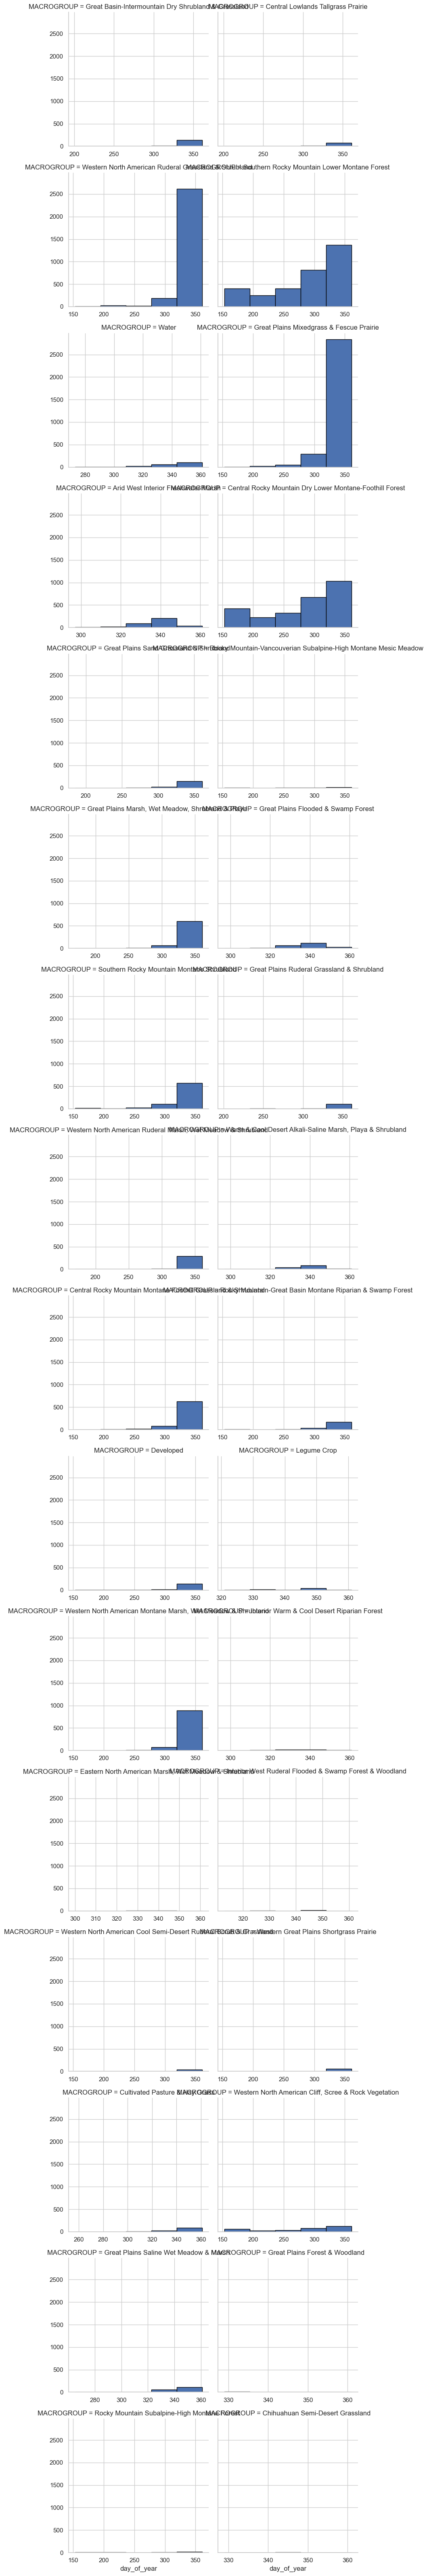

In [154]:
# Create a faceted histogram to see brown-down date distributions
# for each macrogroup.

sns.set(style="whitegrid")
g = sns.FacetGrid(veg_avg_dates_gdf, col="MACROGROUP",
                  col_wrap=2, height=4, sharex=False)

# Map the histogram to each facet
g.map(plt.hist, "day_of_year", bins=5, edgecolor='black')

plt.show()

## **Results**

### Fig 1. Interactive Map of brown-down dates by pixel

This code has a bug where the polygons map does not line up with the raster layer. In the upper portion of the plot it is clear that the datasets are on different projections. However, the CRS of both datasets is the same. See the bug report here: https://github.com/earthlab-education/ea-bug-queue/issues/6.

In [54]:
type(dates_da)
print(dates_da.rio.crs)
type(veg_gdf)
print(veg_gdf.crs)

EPSG:4326
EPSG:4326


In [ ]:
# Simplify geometry to speed up plotting
simplified_veg_gdf = veg_gdf.copy()
simplified_veg_gdf['geometry'] = veg_gdf['geometry'].simplify(
    tolerance=0.0001)  # Adjust the tolerance as needed

# Convert the 'STRING_COLUMN' to a string type
simplified_veg_gdf['SCIENTIFICNAME'] = simplified_veg_gdf['SCIENTIFICNAME'].astype(str)

## Problem persists even when using .hvplot
# # Create veg polygons map
# veg_map = simplified_veg_gdf.hvplot(
#     geo=True,
#     line_color='black',
#     fill_alpha=0,
#     tiles='EsriImagery',
#     hover_cols=['SCIENTIFICNAME']
# ).opts(
#     width=500,
#     height=800,
#     show_legend=False,  # Set legend to False to remove it
#     tools=['hover']
# )

veg_map = gv.Polygons(simplified_veg_gdf, vdims=['SCIENTIFICNAME']
    # tiles='EsriImagery'
).opts(
    width=500,
    height=800,
    show_legend=False,  # Set legend to False to remove it
    color=None,
    tools=['hover']
)

# Convert the xarray DataArray to a GeoViews object
dates_gvds = gv.Dataset(
    dates_da, kdims=['x', 'y', 'year'], vdims=['day_of_year'])


# Create a GeoViews plot
dates_plot = dates_gvds.to(gv.Image).opts(cmap='viridis_r',
                                          colorbar=True,
                                          alpha=0.5,
                                          width=600,
                                          height=800,
                                          show_legend=False)


dates_veg_plot = (dates_plot
                  * veg_map).opts(tools=['hover'],
                                  width=600,
                                  height=800,
                                  show_legend=False)

# Display plot
dates_veg_plot

### Fig 2. Brown-down dates of vegetation patches vary among grasslands compared to forests, and within grassland types, in Boulder County, CO

This chloropleth plot of vegetation patches in 2021 shows that in the western part of the region, the 10th percentile brownest day of year (a proxy for the vegetation "brown-down" or senescence) was in June for most montane forest vegetation patches, but for most grassland vegetation patches, it was in December. The highly destructive Marshall Fire, which occurred on December 30, 2021 in grasslands south of Boulder (Fovell et al. 2022), in the southern portion of the below map, burned weeks after the vegetation browned-down in December.

In [159]:
# Set geometry
veg_avg_dates_gdf = veg_avg_dates_gdf.set_geometry('geometry')

veg_avg_dates_2021_gdf = veg_avg_dates_gdf[veg_avg_dates_gdf['year'] == 2021]
veg_avg_dates_2021_gdf['SCIENTIFICNAME'] = veg_avg_dates_2021_gdf['SCIENTIFICNAME'].astype(str)

browndown_2021_plot = veg_avg_dates_2021_gdf.hvplot.polygons(
    geo=True,
    c='day_of_year',
    cmap='viridis',
    project=True,
    hover_cols=['SCIENTIFICNAME', 'date_of_browndown']
).opts(
    frame_width=600,
    frame_height=400,
    title='Vegetation brown-down in 2021',
    framewise=True,  # Enable the time slider
)

# Show the plot
browndown_2021_by_veg_patch_plot= browndown_2021_plot * gv.tile_sources.EsriImagery

hv.save(browndown_2021_by_veg_patch_plot, 'browndown_2021_by_veg_patch.html')

/Users/advythramachandran/miniconda3/envs/earth-analytics-python/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
import pandas as pd
import geopandas as gpd
import geoviews as gv
import param
import panel as pn
gv.extension('bokeh')

In [ ]:
gdf = veg_avg_dates_gdf
print(gdf.crs)

In [ ]:
gdf = gdf.to_crs(epsg=3857)

In [ ]:
gv.Polygons(gdf
            .reset_index(),
            vdims=['day_of_year'])

In [ ]:
# gdf = gdf.reset_index()

opts = dict(width=600, height=600, tools=['hover'], colorbar=True, cmap='RdBu',
            color='day_of_year', symmetric=True, toolbar='above', line_color='black',
            )


class PreMEI(param.Parameterized):
    year = param.Integer(default=2017, bounds=(2015, 2022))

    def chloro(self):
        return gv.Polygons(gdf[gdf['year'] == self.year], vdims=['day_of_year']
                           )

    @param.depends('year')
    def view_chloro(self):
        return gv.DynamicMap(self.chloro).opts(**opts)


p = PreMEI()
doc = pn.Row(p.param, p.view_chloro)
doc

In [ ]:
veg_avg_dates_gdf.hvplot.polygons(
    geo=True,
    c='day_of_year',
    cmap='viridis',
    project=True)

### **Fig 3. Brown-down date by vegetation alliance over time.**

In [158]:
veg_avg_dates_gdf

,index,year,region,spatial_ref,day_of_year,date_of_browndown,OBJECTID,USNVCKEY,SCIENTIFICNAME,COLLOQUIALNAME,MACROGROUP,SUBCLASS,CONSTARGET,WETLAND,ACRES,URL,GlobalID,Shape.STArea(),Shape.STLength(),geometry
0,0,2014,10448,0,361.0,2014-12-27,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
1,1,2015,10448,0,345.0,2015-12-11,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
2,2,2016,10448,0,345.0,2016-12-10,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
3,3,2017,10448,0,345.0,2017-12-11,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
4,4,2018,10448,0,329.0,2018-11-25,10448,CEGL001651,Achnatherum hymenoides Shale Barren Grassland,None,Great Basin-Intermountain Dry Shrubland & Gras...,Cool Semi-Desert Scrub & Grassland,Mixedgrass Prairie Mosaic,None,1.059736,https://explorer.natureserve.org/Taxon/ELEMENT...,{CB5F0607-14AF-45B7-BA69-03616BD82351},46161.924356,1217.040849,"POLYGON ((-105.28852 40.08049, -105.28856 40.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19012,19012,2018,20748,0,345.0,2018-12-11,20748,None,None,None,None,None,None,None,9.648047,None,{7AE3C8CA-CA41-43DE-B3A6-0AA47F2E73A6},420267.240374,3053.227629,"POLYGON ((-105.22225 39.99893, -105.22225 39.9..."
19013,19013,2019,20748,0,329.0,2019-11-25,20748,None,None,None,None,None,None,None,9.648047,None,{7AE3C8CA-CA41-43DE-B3A6-0AA47F2E73A6},420267.240374,3053.227629,"POLYGON ((-105.22225 39.99893, -105.22225 39.9..."
19014,19014,2020,20748,0,345.0,2020-12-10,20748,None,None,None,None,None,None,None,9.648047,None,{7AE3C8CA-CA41-43DE-B3A6-0AA47F2E73A6},420267.240374,3053.227629,"POLYGON ((-105.22225 39.99893, -105.22225 39.9..."
19015,19015,2021,20748,0,345.0,2021-12-11,20748,None,None,None,None,None,None,None,9.648047,None,{7AE3C8CA-CA41-43DE-B3A6-0AA47F2E73A6},420267.240374,3053.227629,"POLYGON ((-105.22225 39.99893, -105.22225 39.9..."


In [ ]:
veg_type_dates = (veg_avg_dates_gdf
                  .drop(columns='geometry')
                  .assign(year=pd.to_datetime(veg_avg_dates_gdf['year'], format='%Y'))
                  # Filter rows containing 'grassland' in the 'name' column
                  .loc[gdf['SCIENTIFICNAME'].str.contains('grassland', case=False, na=False)]
                  # Filter out rows containing 'grassland' or 'shrubland' in the 'name' column
                  .loc[~gdf['SCIENTIFICNAME'].str.contains('shrubland', case=False, na=False)]
                  .groupby(['SCIENTIFICNAME', 'year'])
                  .agg(avg_doy=('day_of_year', 'mean'))
                  )
veg_type_dates

In [ ]:
line_plot = veg_type_dates.hvplot.line(x='year', y='avg_doy', by='SCIENTIFICNAME', line_width=2, width=600, height=600
                                       ).opts(show_legend=False,
                                              text_font_size='10pt',
                                              ylabel='average date of brown-down',
                                              title="Brown-down dates by year for grassland types in Boulder County, CO"
                                              )


line_plot

### **Figure 4. Brown-down dates in grasslands versus forests.**


In [ ]:
grassland_pooled_dates = (veg_avg_dates_gdf
                          .drop(columns='geometry')
                          .assign(year=pd.to_datetime(veg_avg_dates_gdf['year'], format='%Y'))
                          # Filter rows containing 'grassland' in the 'name' column
                          .loc[gdf['SCIENTIFICNAME'].str.contains('grassland', case=False, na=False)]
                          # Filter out rows containing 'grassland' or 'shrubland' in the 'name' column
                          .loc[~gdf['SCIENTIFICNAME'].str.contains('shrubland', case=False, na=False)]
                          .groupby(['year'])
                          .agg(avg_doy=('day_of_year', 'mean'))
                          )
grassland_pooled_dates

In [ ]:
grassland_avg_browndown_plot = grassland_pooled_dates.hvplot.line(x='year', y='avg_doy', line_width=2, width=600, height=400
                                                                  ).opts(
    ylabel='average date of brown-down',
    title="Brown-down dates by year across grasslands in Boulder County, CO"
)
grassland_avg_browndown_plot

## **Potential Future Directions**

Aside from those already identified above, further work could:

1. investigate the drivers of differences in vegetation he
2. 

## **References**


